:# **UWMGI: Unet PyTorch [Train] **

# Import Libraries 

In [ ]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import seaborn as sns
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# # For descriptive error messages
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import cupy as cp

def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths):
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx in range(msks.shape[0]):
        height = heights[idx].item()
        width = widths[idx].item()
        msk = cv2.resize(msks[idx], 
                         dsize=(width, height), 
                         interpolation=cv2.INTER_NEAREST) # back to original shape
        rle = [None]*3
        for midx in [0, 1, 2]:
            rle[midx] = mask2rle(msk[...,midx])
        pred_strings.extend(rle)
        pred_ids.extend([ids[idx]]*len(rle))
        pred_classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    return pred_strings, pred_ids, pred_classes

# CFG 

In [ ]:
class CFG:
    seed          = 42
    debug         = False 
    model_name    = 'Unet'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = (224, 224)
    epochs        = 20
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 5e-5
    T_max         = 12
    T_0           = 12
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    fold_selected = 1
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [ ]:
df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape)

(115488, 3)


In [ ]:
df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
#--------------------------------------------------------------------------
TRAIN_DIR="../input/uw-madison-gi-tract-image-segmentation/train"
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list
#--------------------------------------------------------------------------
path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

#--------------------------------------------------------------------------
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
#--------------------------------------------------------------------------
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
#--------------------------------------------------------------------------
del x,path_partial_list,tmp_df
#--------------------------------------------------------------------------
df.head(5)


,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [ ]:
# RESTRUCTURE  DATAFRAME
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
28659,case36_day14_slice_0036,,,27047 6 27312 8 27578 8 27844 8 28109 9 28375 ...,../input/uw-madison-gi-tract-image-segmentatio...,36,14,0036,266,266,1
621,case77_day0_slice_0046,,,,../input/uw-madison-gi-tract-image-segmentatio...,77,0,0046,266,266,0
13728,case19_day18_slice_0081,17824 3 18182 7 18540 11 18899 20 19258 24 196...,30039 2 30397 7 30756 11 31116 15 31475 25 318...,,../input/uw-madison-gi-tract-image-segmentatio...,19,18,0081,360,310,2
24702,case108_day13_slice_0143,,,,../input/uw-madison-gi-tract-image-segmentatio...,108,13,0143,266,266,0
34099,case47_day27_slice_0068,33239 6 33597 10 33956 11 34314 14 34673 15 35...,26816 6 27175 8 27534 11 27893 13 28252 16 286...,,../input/uw-madison-gi-tract-image-segmentatio...,47,27,0068,360,310,2


# RLE

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# Create Folds

In [ ]:
# SAMPLES
train_mask = list(df_train[df_train['large_bowel']!=''].index)
train_mask += list(df_train[df_train['small_bowel']!=''].index)
train_mask += list(df_train[df_train['stomach']!=''].index)

df_train=df_train[df_train.index.isin(train_mask)]     
df_train.reset_index(inplace=True,drop=True)
print(df_train.shape)

(16590, 11)


In [ ]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=CFG.fold_selected].index
valid_ids = df_train[df_train["fold"]==CFG.fold_selected].index

df_train.groupby('fold').size()

fold
1    3973
2    2806
3    3656
4    3121
5    3034
dtype: int64

In [ ]:
display(df_train.groupby(['fold','count'])['id'].count())

fold  count
1     1         556
      2        2664
      3         753
2     1         362
      2        1843
      3         601
3     1         607
      2        2348
      3         701
4     1         566
      2        2018
      3         537
5     1         377
      2        2048
      3         609
Name: id, dtype: int64

# Dataset

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, subset="train", transforms=None):
        self.df = df
        self.subset = subset
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, index): 
        masks = np.zeros((CFG.img_size[0],CFG.img_size[1], 3), dtype=np.float32)
        id_ = self.df['id'].iloc[index]
        img_path=self.df['path'].iloc[index]
        w=self.df['width'].iloc[index]
        h=self.df['height'].iloc[index]
        img = self.__load_img(img_path)
        if self.subset == 'train':
            for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                rles=self.df[j].iloc[index]
                mask = rle_decode(rles, shape=(h, w, 1))
                mask = cv2.resize(mask, CFG.img_size)
                masks[:,:,k] = mask
        
        masks = masks.transpose(2, 0, 1)
        img = img.transpose(2, 0, 1)

        if self.subset == 'train': return torch.tensor(img), torch.tensor(masks)
        else: return torch.tensor(img), id_, h, w
        

    def __load_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = (img - img.min())/(img.max() - img.min())*255.0 
        img = cv2.resize(img, CFG.img_size)
        img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
        img = img.astype(np.float32) /255.
        return img
    



# Augmentations

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.OneOf([
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.2),

        ], p=1.0),
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# DataLoader

In [ ]:

train_dataset = BuildDataset(df_train, transforms=data_transforms['train'])
valid_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)], transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs,num_workers=4, shuffle=False, pin_memory=True)
    

imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

#  Visualization

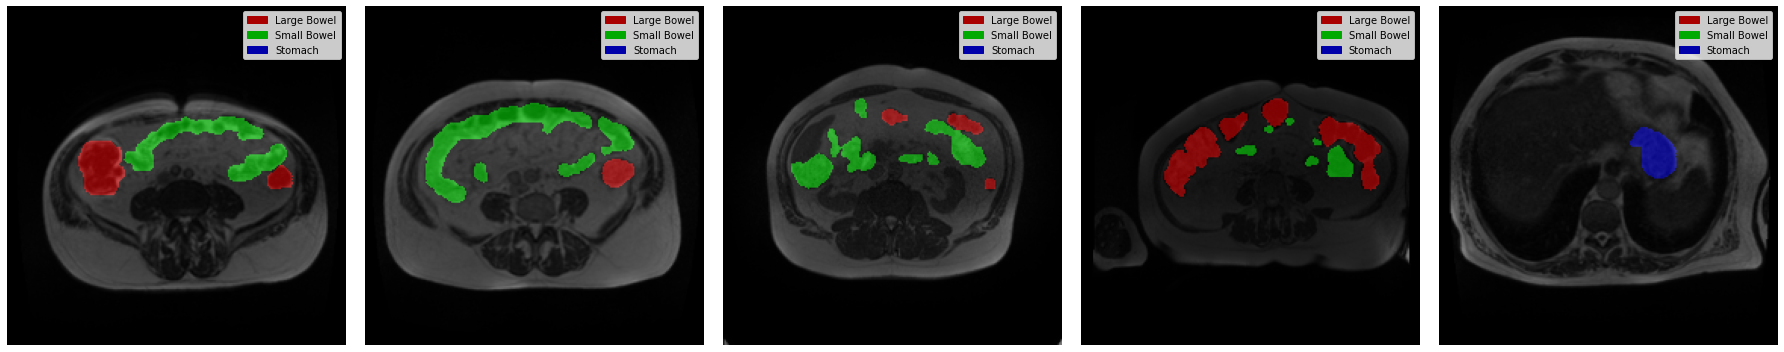

In [ ]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
        msk = msks[idx,].permute((1, 2, 0)).numpy()
#         for midx in [0, 1, 2]:
#             print(mask2rle(msk[...,midx]))
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

plot_batch(imgs, msks, size=5)

In [ ]:
gc.collect()

18171

# UNet Model


In [ ]:
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation).cuda()


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False).cuda()

def upsample(scale_factor, mode='bilinear', align_corners=True):
    return nn.Upsample(scale_factor=scale_factor, mode=mode, align_corners=align_corners).cuda()

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True)
    ).cuda()

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer0 = nn.Sequential(
#             nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
#             norm_layer(self.inplanes),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         )
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
#         x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2],
                   **kwargs)

def resnet50(progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3],
                   **kwargs)

# 🔧 Loss Function

In [ ]:
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1e-5):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice

In [ ]:
# def FocalLoss(
#     inputs: torch.Tensor,
#     targets: torch.Tensor,
#     alpha: float = 0.25,
#     gamma: float = 2,
#     reduction: str = "sum",
# ):
#     p = torch.sigmoid(inputs)
#     ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction=reduction)
#     p_t = p * targets + (1 - p) * (1 - targets)
#     loss = ce_loss * ((1 - p_t) ** gamma)

#     if alpha >= 0:
#         alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
#         loss = alpha_t * loss

#     if reduction == "mean":
#         loss = loss.mean()
#     elif reduction == "sum":
#         loss = loss.sum()

#     return loss

In [ ]:
# DiceLoss    = DiceLoss()
BCELoss     = torch.nn.BCEWithLogitsLoss()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return BCELoss(y_pred, y_true)

# Training Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    model.to(device)
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    if scheduler is not None:
        scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# Validation Function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# Training

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients

    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics

        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
           # run.summary["Best Jaccard"] = best_jaccard
           # run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

# Start Training

In [ ]:
for fold in range(1):
    print(f'#'*35)
    print(f'######### Fold: {fold}')
    print(f'#'*35)
    model = UNet(num_classes=CFG.num_classes)
#     model.load_state_dict(torch.load('./best_epoch-00.bin'))
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    

###################################
######### Fold: 0
###################################
cuda: Tesla P100-PCIE-16GB

Epoch 1/20

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, gpu_memory=8.64 GB, lr=0.00197, valid_loss=0.0208]


Valid Dice: 0.6437 | Valid Jaccard: 0.5608
Valid Score Improved (-inf ---> 0.6437)
Model Saved


Epoch 2/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.15it/s, gpu_memory=8.68 GB, lr=0.00187, valid_loss=0.0131]


Valid Dice: 0.7864 | Valid Jaccard: 0.7058
Valid Score Improved (0.6437 ---> 0.7864)
Model Saved


Epoch 3/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, gpu_memory=8.70 GB, lr=0.00171, valid_loss=0.0121]


Valid Dice: 0.8007 | Valid Jaccard: 0.7241
Valid Score Improved (0.7864 ---> 0.8007)
Model Saved


Epoch 4/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, gpu_memory=8.70 GB, lr=0.00151, valid_loss=0.0100]


Valid Dice: 0.8414 | Valid Jaccard: 0.7689
Valid Score Improved (0.8007 ---> 0.8414)
Model Saved


Epoch 5/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, gpu_memory=8.68 GB, lr=0.00128, valid_loss=0.0088]


Valid Dice: 0.8647 | Valid Jaccard: 0.7968
Valid Score Improved (0.8414 ---> 0.8647)
Model Saved


Epoch 6/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, gpu_memory=8.70 GB, lr=0.00103, valid_loss=0.0078]


Valid Dice: 0.8801 | Valid Jaccard: 0.8154
Valid Score Improved (0.8647 ---> 0.8801)
Model Saved


Epoch 7/20

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, gpu_memory=8.70 GB, lr=0.00077, valid_loss=0.0072]


Valid Dice: 0.8860 | Valid Jaccard: 0.8238
Valid Score Improved (0.8801 ---> 0.8860)
Model Saved


Epoch 8/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, gpu_memory=8.68 GB, lr=0.00054, valid_loss=0.0067]


Valid Dice: 0.8959 | Valid Jaccard: 0.8369
Valid Score Improved (0.8860 ---> 0.8959)
Model Saved


Epoch 9/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, gpu_memory=8.71 GB, lr=0.00034, valid_loss=0.0060]


Valid Dice: 0.9091 | Valid Jaccard: 0.8524
Valid Score Improved (0.8959 ---> 0.9091)
Model Saved


Epoch 10/20

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, gpu_memory=8.70 GB, lr=0.00018, valid_loss=0.0055]


Valid Dice: 0.9197 | Valid Jaccard: 0.8663
Valid Score Improved (0.9091 ---> 0.9197)
Model Saved


Epoch 11/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.15it/s, gpu_memory=8.68 GB, lr=0.00008, valid_loss=0.0050]


Valid Dice: 0.9274 | Valid Jaccard: 0.8768
Valid Score Improved (0.9197 ---> 0.9274)
Model Saved


Epoch 12/20

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.04it/s, gpu_memory=8.71 GB, lr=0.00005, valid_loss=0.0047]


Valid Dice: 0.9323 | Valid Jaccard: 0.8836
Valid Score Improved (0.9274 ---> 0.9323)
Model Saved


Epoch 13/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, gpu_memory=8.70 GB, lr=0.00008, valid_loss=0.0046]


Valid Dice: 0.9349 | Valid Jaccard: 0.8869
Valid Score Improved (0.9323 ---> 0.9349)
Model Saved


Epoch 14/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, gpu_memory=8.68 GB, lr=0.00018, valid_loss=0.0046]


Valid Dice: 0.9354 | Valid Jaccard: 0.8876
Valid Score Improved (0.9349 ---> 0.9354)
Model Saved


Epoch 15/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, gpu_memory=8.71 GB, lr=0.00034, valid_loss=0.0049]


Valid Dice: 0.9303 | Valid Jaccard: 0.8809


Epoch 16/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.15it/s, gpu_memory=8.71 GB, lr=0.00054, valid_loss=0.0054]


Valid Dice: 0.9173 | Valid Jaccard: 0.8641


Epoch 17/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, gpu_memory=8.71 GB, lr=0.00077, valid_loss=0.0058]


Valid Dice: 0.9134 | Valid Jaccard: 0.8586


Epoch 18/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, gpu_memory=8.71 GB, lr=0.00102, valid_loss=0.0061]


Valid Dice: 0.9086 | Valid Jaccard: 0.8514


Epoch 19/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, gpu_memory=8.71 GB, lr=0.00128, valid_loss=0.0063]


Valid Dice: 0.9039 | Valid Jaccard: 0.8459


Epoch 20/20

Valid : 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, gpu_memory=8.71 GB, lr=0.00151, valid_loss=0.0065]


Valid Dice: 0.8983 | Valid Jaccard: 0.8398


Training complete in 3h 58m 27s
Best Score: 0.8876


# Loss, Dice,Jaccard Curves

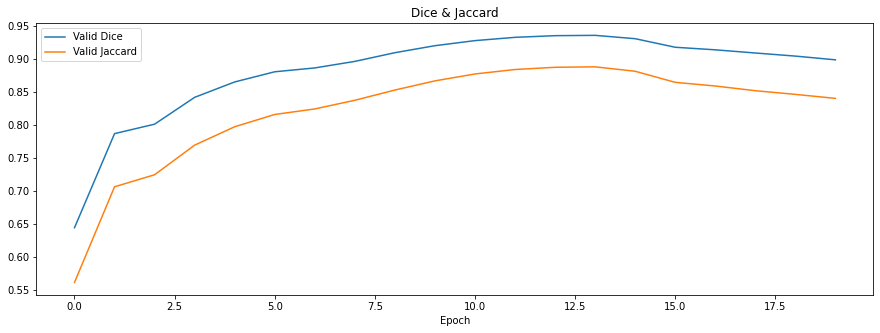

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(CFG.epochs),history['Valid Dice'],label='Valid Dice')
plt.plot(range(CFG.epochs),history['Valid Jaccard'],label='Valid Jaccard')
plt.title('Dice & Jaccard'); plt.xlabel('Epoch'); plt.ylabel('');plt.legend(); 
plt.show()

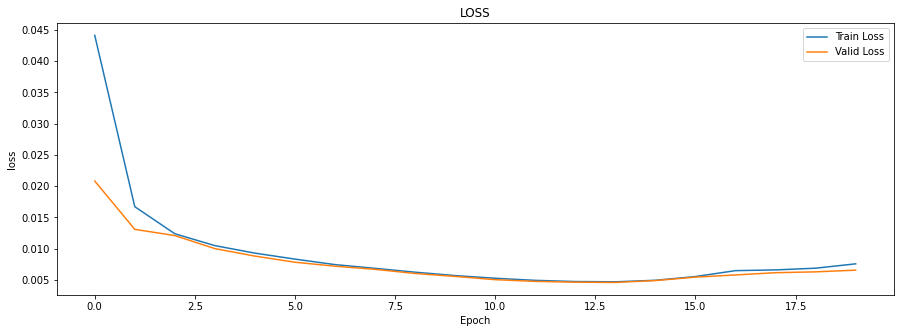

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(CFG.epochs),history['Train Loss'],label='Train Loss')
plt.plot(range(CFG.epochs),history['Valid Loss'],label='Valid Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

# Prediction

In [ ]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)], 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model.load_state_dict(torch.load(f"best_epoch-{fold:02d}.bin"))
    model.cuda()
    model.eval()
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

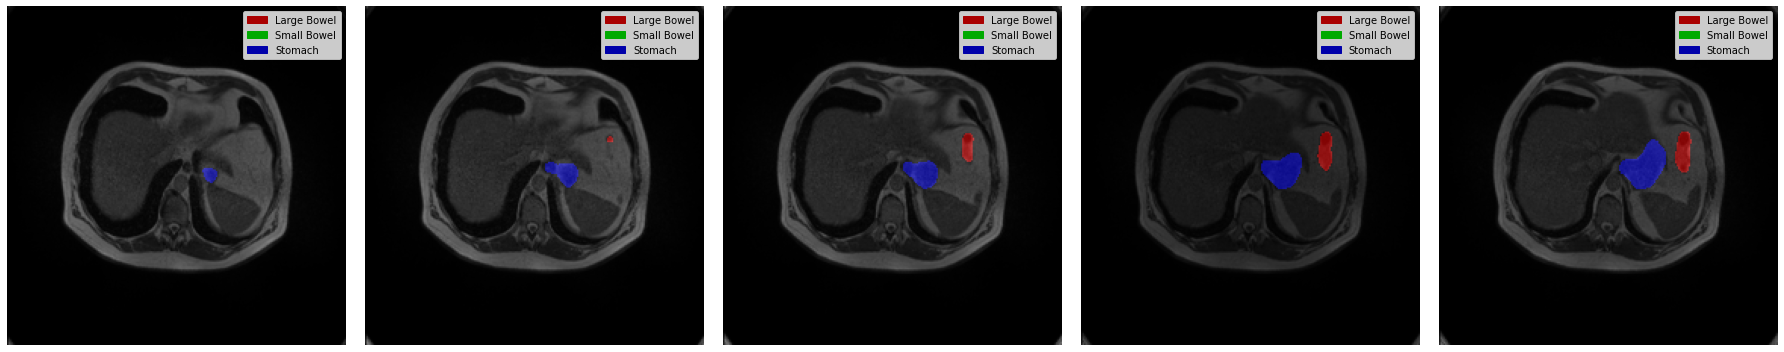

In [ ]:
plot_batch(imgs, preds, size=5)

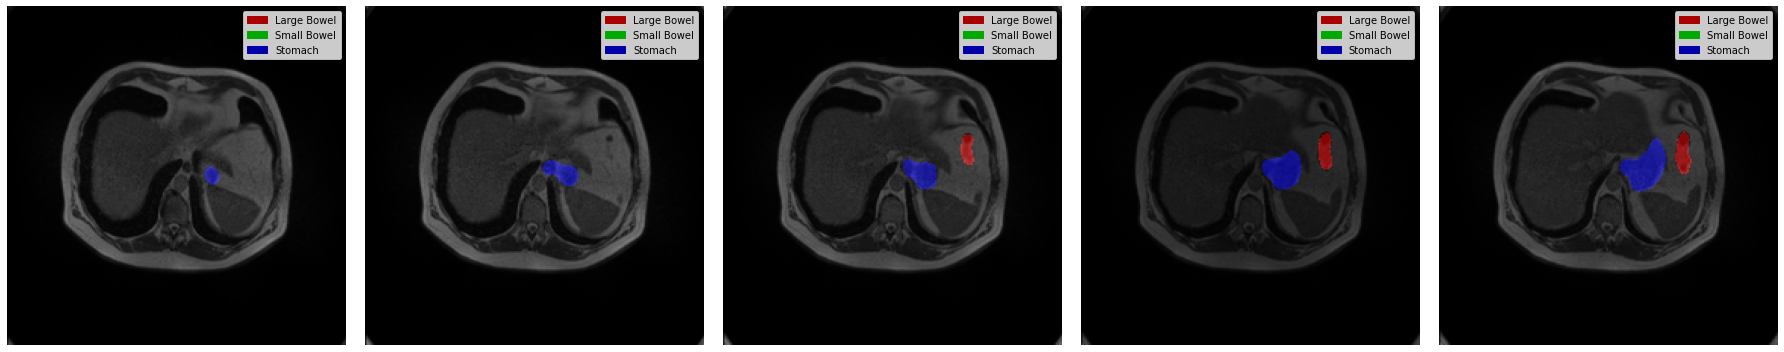

In [ ]:
plot_batch(imgs, msks, size=5)

# Computing Dice & Jaccard for Classes

In [ ]:
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ["Large Bowel", "Small Bowel", "Stomach"]) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ["Large Bowel", "Small Bowel", "Stomach"]) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [ ]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """

    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data[0], data[1]
            imgs, targets = imgs.to(CFG.device), targets.to(CFG.device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])
                
    return dice_scores_per_classes, iou_scores_per_classes

In [ ]:
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, test_loader, ["Large Bowel", "Small Bowel", "Stomach"]
    )

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['Large Bowel Dice', 'Small Bowel Dice', 'Stomach Dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['Large Bowel Jaccard', 'Small Bowel Jaccard', 'Stomach Jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['Large Bowel Dice', 'Large Bowel Jaccard', 
                                      'Small Bowel Dice', 'Small Bowel Jaccard', 
                                      'Stomach Dice', 'Stomach Jaccard']]
val_metics_df.head(3)

,Large Bowel Dice,Large Bowel Jaccard,Small Bowel Dice,Small Bowel Jaccard,Stomach Dice,Stomach Jaccard
0,1.000000e+00,1.000000e+00,1.0,1.0,0.708333,0.548387
1,8.333333e-11,8.333333e-11,1.0,1.0,0.835165,0.716981
2,8.333333e-01,7.142857e-01,1.0,1.0,0.907563,0.830769


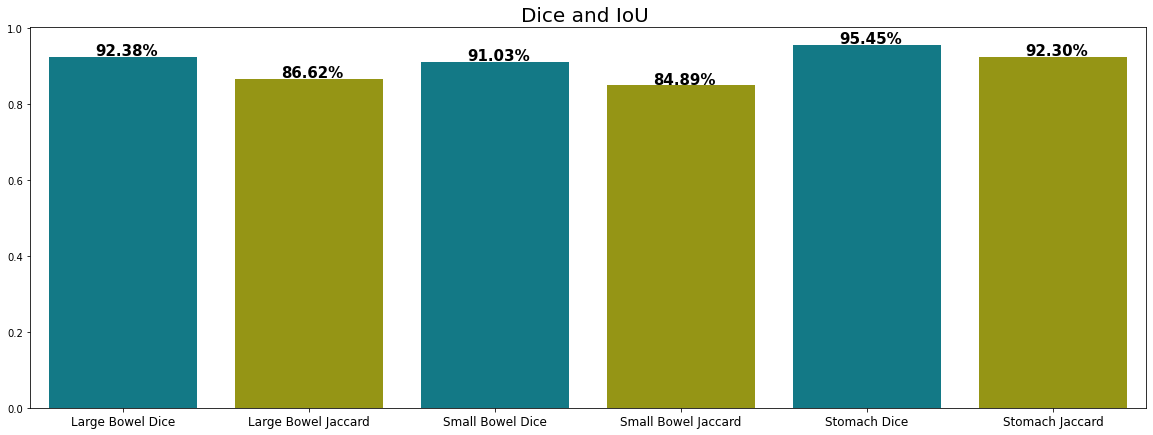

In [ ]:
colors = ['#008899', '#aaaa00', '#008899', '#aaaa00', '#008899', '#aaaa00']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(20, 7));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=12, rotation=0);
ax.set_title("Dice and IoU ", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.2f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height() + 0.005
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")


# Submission

In [ ]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
#     row['id'] = f'case{case}_day{day}_slice_{slice_}'
    return row

In [ ]:
sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
if not len(sub_df):
    debug = True
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    sub_df = sub_df.drop(columns=['class','segmentation']).drop_duplicates()
else:
    debug = False
    sub_df = sub_df.drop(columns=['class','predicted']).drop_duplicates()
sub_df = sub_df.progress_apply(get_metadata,axis=1)

100%|██████████| 1000/1000 [00:01<00:00, 728.95it/s]


In [ ]:
if debug:
    paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/**/*png',recursive=True)
#     paths = sorted(paths)
else:
    paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/test/**/*png',recursive=True)
#     paths = sorted(paths)
path_df = pd.DataFrame(paths, columns=['path'])
path_df = path_df.progress_apply(path2info, axis=1)
path_df.head()

100%|██████████| 38496/38496 [01:28<00:00, 433.13it/s]


,path,height,width,case,day,slice
0,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,6
1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,82
2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,113
3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,76
4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,125


In [ ]:
test_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')
test_df.head()

,id,case,day,slice,path,height,width
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
1,case123_day20_slice_0002,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
2,case123_day20_slice_0003,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
3,case123_day20_slice_0004,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
4,case123_day20_slice_0005,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266


In [ ]:
test_dataset = BuildDataset(test_df, subset='test', transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                          num_workers=4, shuffle=False, pin_memory=False)

In [ ]:
@torch.no_grad()
def infer(test_loader, num_log=1, thr=0.5):
    msks = []; imgs = [];
    pred_strings = []; pred_ids = []; pred_classes = [];
    model = UNet()
    model.load_state_dict(torch.load(f"best_epoch-00.bin"))
    model.cuda()
    model.eval()
    for idx, (img, ids, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer')):
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        size = img.size()
        msk = []
        msk = torch.zeros((size[0], 3, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        out   = model(img) # .squeeze(0) # removing batch axis
        out   = nn.Sigmoid()(out) # removing channel axis
        msk = (out.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks2rles(msk, ids, heights, widths)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
        del img, msk, out, result
        gc.collect()
        torch.cuda.empty_cache()
    return pred_strings, pred_ids, pred_classes

In [ ]:
pred_strings, pred_ids, pred_classes = infer(test_loader)

Infer: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it]


In [ ]:
pred_df = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_strings
})
if not debug:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
    del sub_df['predicted']
else:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    del sub_df['segmentation']
    
sub_df = sub_df.merge(pred_df, on=['id','class'])
sub_df.to_csv('submission.csv',index=False)
display(sub_df.head(5))

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,29910 1 30175 4 30442 6 30533 5 30708 6 30799 ...
1,case123_day20_slice_0001,small_bowel,28613 5 28879 5 29143 8 29406 12 29671 13 2993...
2,case123_day20_slice_0001,stomach,26725 4 26989 7 27255 7 27519 10 27785 11 2805...
3,case123_day20_slice_0002,large_bowel,26404 5 26669 8 26936 9 27202 9 27470 7 27739 ...
4,case123_day20_slice_0002,small_bowel,26480 9 26745 11 27011 12 27277 12 27542 14 27...
